# Fourier Analysis Networks (FANs)

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [2]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# count how many trainable weights the model has
def count_parameters(model) -> None:
    total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of parameters: {total_params}')

# Building the FAN layer and a FAN model

Fourier Analysis is a mathematical way of breaking down functions into the frequencies that make them up. The analysis is based on the Fourier Series, which represents a periodic function as an infinite sum of sine and cosine terms:

$$
f_{\text{S}}(x) \triangleq a_0 + \sum_{n=1}^{N} \left( a_n \cos\left(\frac{2\pi nx}{T}\right) + b_n \sin\left(\frac{2\pi nx}{T}\right) \right)
$$

The coefficients a(n) and b(n) are calculated by integrating the function over one period. One of the best parts of the Fourier series is that it can even be extended to handle non-periodic functions. This is done using the Fourier transform that treats the non-periodic functions as if they were part of a signal with an infinitely large period ($T → ∞$), allowing us to break them into frequency components as well. While the Fourier series represents periodic functions as the sums of discrete frequencies, the Fourier Transform represents non-periodic functions as a continuous spectrum of frequencies.

To build a neural network from this, we first parameterize its coefficients as learnable weights and reformulate it to a vector representation:

$$
f_{\text{S}}(x) \triangleq B + W_\text{out}[\cos(W_\text{in}x)|| \sin(W_\text{in}x)]
$$

Instead of applying $f_\text{in}$ and $f_\text{out}$​ sequentially, we use both simultaneously to ensure that the intermediate layers contribute to periodicity modeling and refining the coefficients as well. This leads to the FAN layer $\phi(x)$ defined as:

$$
\phi(x) \triangleq [\cos(W_px)|| \sin(W_px)|| \sigma(B_{\bar{p}} + W_{\bar{p}}x)]
$$

In [4]:
class FANLayer(nn.Module):
    """
    The Fourier Analysis Network (FAN) layer.
    - Defined in https://arxiv.org/abs/2410.02675
    """

    def __init__(self, input_dim, output_dim, glu=True, bias=True) -> None:
        super(FANLayer, self).__init__()
        # d_p is set to a quarter of output_dim as in the original paper
        # here, output_dim is treated as the hidden dimension.
        d_p= output_dim // 4
        # Wp projects to a lower-dimensional "periodic" space (d_p dimensions)
        self.Wp= nn.Linear(input_dim, d_p, bias=False)
         # Wp_bar projects the input to the full hidden dimension (output_dim)
        self.Wp_bar= nn.Linear(input_dim, output_dim, bias=bias)
        # if using GLU, apply a gating parameter (a learnable scalar) to balance the two branches
        self.gate= nn.Parameter(torch.randn(1)) if glu else None
        self.activation= nn.SiLU() if glu else nn.GELU()

    def forward(self, x):
        # compute the periodic projection and apply cosine and sine
        cos_term= torch.cos(self.Wp(x))  # (B, T, d_p)
        sin_term= torch.sin(self.Wp(x))  # (B, T, d_p)
        # compute the non-periodic branch with activation
        non_periodic_term= self.activation(self.Wp_bar(x))  # (B, T, output_dim)

        if self.gate is not None:
            # compute the gate value and modulate both branches
            gate= torch.sigmoid(self.gate)
            cos_term= gate * cos_term
            sin_term= gate * sin_term
            non_periodic_term= (1 - gate) * non_periodic_term

        # concatenate the cosine, sine, and non-periodic components along the last dimension
        return torch.cat([cos_term, sin_term, non_periodic_term], dim=-1)


The entire FAN is defined as the stacking of FAN layers $\phi(x)$:

$$
\text{FAN}(x) = \phi_L \circ  \phi_{L-1} \circ \cdots \circ \phi_{1} \circ x,
$$
where
$$
\small{
\phi_l(x) = \left\{
  \begin{array}{ll}
   [\cos(W^l_px)|| \sin(W^l_px)|| \sigma(B^l_{\bar{p}} + W^l_{\bar{p}}x)],&\text{if } l < L, \\
   B^L + W^Lx,&\text{if } l = L
  \end{array}
\right.}
$$

This neural network is called the Fourier Analysis Network or FAN.

**NOTE:** Gating Complexity -- If a single scalar gate is too limiting, we might experiment with a more flexible and complex gating design (e.g., a vector per token, allowing variation across both tokens and dimensions).

In [5]:
class FAN(nn.Module):
    """
    The FAN is defined as the stacking of FAN layers.
    """

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, glu=True, bias=True) -> None:
        super(FAN, self).__init__()
        # Implementation of FAN layers before the last layer
        self.layers= nn.ModuleList()
        for _ in range(num_layers - 1):
            self.layers.append(FANLayer(input_dim, hidden_dim, glu, bias))
            # Update input_dim after each layer to match the output of FANLayer
            # Each FANLayer outputs: 2*(hidden_dim//4)+hidden_dim, i.e., hidden_dim//2+hidden_dim
            input_dim= hidden_dim // 2 + hidden_dim

        # Implementation of the final projection layer to the desired output_dim
        self.WL= nn.Linear(input_dim, output_dim, bias=bias)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                # normal_ presented the faster convergence
                nn.init.normal_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)


    def forward(self, x):
        for layer in self.layers:
            x= layer(x)

        return self.WL(x)


In [6]:
class FANFeedForward(nn.Module):
    """
    The Feed Forward Network (FFN) based on the FAN architecture.
    nn.init.normal_ on this network improves fast convergence
    - This module can switch between a Gated-based FAN-FFN and a FAN-FFN on the glu flag.
    """

    def __init__(self, n_embed, d_ff, dropout=0.1, glu=True, bias=True) -> None:
        super(FANFeedForward, self).__init__()
        assert d_ff % 4 == 0, "d_ff must be divisible by 4"
        # FAN layers
        self.fan_l1= FANLayer(n_embed, d_ff, glu, bias)
        fan_d_ff= d_ff // 2 + d_ff
        self.fan_l2= FANLayer(fan_d_ff, d_ff, glu, bias)
        # FAN out layer
        self.dropout= nn.Dropout(p=dropout)
        self.WL= nn.Linear(fan_d_ff, n_embed, bias=bias)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                # normal_ presented the faster convergence
                nn.init.normal_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)


    def forward(self, x):
        x= self.fan_l2(self.fan_l1(x))
        x= self.dropout(x)
        x= self.WL(x)

        return x


# MLP model for comparison

The MLP neural network uses a simple linear transformation followed by a non-linear activation in each layer, the FAN integrates periodic transformations (sine and cosine) along with the non-linear activation.

FANs are based on the same theoretical concept that MLPs are based on, i.e. the Universal Approximation Theorem. However, they enhance MLPs by explicitly including periodicity in their architecture. This makes them more expressive than MLPs.

In [7]:
class MLPLayer(nn.Module):
    def __init__(self, input_dim, output_dim, bias=True) -> None:
        super(MLPLayer, self).__init__()
        self.linear= nn.Linear(input_dim, output_dim, bias=bias)
        self.activation= nn.GELU()

    def forward(self, x):
        return self.activation(self.linear(x))



class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bias=True):
        super(MLP, self).__init__()
        self.layers= nn.ModuleList()
        # Implementation of layers before the last layer
        for _ in range(num_layers - 1):
            self.layers.append(MLPLayer(input_dim, hidden_dim, bias))
            input_dim= hidden_dim

        # Implementation of the last layer
        self.layers.append(nn.Linear(hidden_dim, output_dim, bias=bias))

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)


    def forward(self, x):
        for layer in self.layers:
            x= layer(x)

        return x


# Training and Evaluation

Generate a dataset with samples obtained from a uniform distribution between 1 and 10 with added Gaussian noise, based on the equation below.

$$
y = \sin(2πx) + \cos(3πx)
$$

In [ ]:
class SymbolicDataset(Dataset):
    def __init__(self, num_samples, noise_level):
        # Inputs obtained from sampling a uniform distribution
        self.x= np.random.uniform(0, 10, (num_samples, 1)).astype(np.float32)
        #Outputs calculated as per the periodic formula (shown above)
        self.y= (np.sin(2 * np.pi * self.x) + np.cos(3 * np.pi * self.x)).astype(np.float32)
        #Noise addition
        self.y += noise_level * np.random.randn(*self.y.shape).astype(np.float32)

    # Method that returns the number of samples in the dataset
    def __len__(self):
        return len(self.x)

    # Method that retrieves the sample at index 'idx'
    def __getitem__(self, idx):
        x= torch.from_numpy(self.x[idx])
        y= torch.from_numpy(self.y[idx])

        return x, y


In [ ]:
def train_model(train_dataset, val_dataset, model, epochs, batch_size, lr, model_name):
    train_dataloader= DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader= DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Using the MSE loss
    criterion= nn.MSELoss()

    # Using the AdamW optimizer
    optimizer= torch.optim.AdamW(model.parameters(), lr=lr)

    train_losses= []
    val_losses= []

    for epoch in tqdm(range(1, epochs + 1), desc=f"Training {model_name}"):
        # Training phase
        model.train()
        epoch_train_loss= 0.0
        for x_batch, y_batch in train_dataloader:
            x_batch, y_batch= x_batch.to(device), y_batch.to(device)

            # Forward pass
            optimizer.zero_grad()
            preds= model(x_batch)
            loss= criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * x_batch.size(0)

        # Validation phase
        model.eval()
        epoch_val_loss= 0.0
        with torch.no_grad():
            for x_batch, y_batch in val_dataloader:
                x_batch, y_batch= x_batch.to(device), y_batch.to(device)
                preds= model(x_batch)
                loss= criterion(preds, y_batch)
                epoch_val_loss += loss.item() * x_batch.size(0)

        # Computing average losses
        epoch_train_loss /= len(train_dataset)
        epoch_val_loss /= len(val_dataset)
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        # Printing losses every 50 epochs
        if epoch % 50 == 0 or epoch == 1 or epoch == epochs:
            print(f"Epoch {epoch}/{epochs} - {model_name} Training Loss: {epoch_train_loss:.6f}, Validation Loss: {epoch_val_loss:.6f}")

    return train_losses, val_losses


In [ ]:
def evaluate_model(fan_model, fan_gate_model, mlp_model):
    # Creating test dataset sampled evenly (compare it with training data)
    x_test= torch.linspace(0, 10, 1000).reshape(-1, 1).float().to(device)
    y_test= np.sin(2 * np.pi * x_test.cpu().numpy()) + np.cos(3 * np.pi * x_test.cpu().numpy())

    fan_model.eval()
    fan_gate_model.eval()
    mlp_model.eval()

    with torch.no_grad():
        fan_pred= fan_model(x_test).cpu().numpy()
        fan_gate_pred= fan_gate_model(x_test).cpu().numpy()
        mlp_pred= mlp_model(x_test).cpu().numpy()

    # Plotting the results
    plt.figure(figsize=(12, 6))

    plt.plot(x_test.cpu().numpy(), y_test, label="True Function", color="black", linestyle="dashed")
    plt.plot(x_test.cpu().numpy(), fan_pred, label="FAN Prediction", color="blue", alpha=0.7)
    plt.plot(x_test.cpu().numpy(), fan_gate_pred, label="FAN Gated Prediction", color="green", alpha=0.7)
    plt.plot(x_test.cpu().numpy(), mlp_pred, label="MLP Prediction", color="red", alpha=0.7)

    plt.legend()

    plt.title("Comparison of FAN, FAN Gated, and MLP on Symbolic Dataset")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.show()


In [ ]:
# Preparing dataset
dataset= SymbolicDataset(num_samples=1000, noise_level=0.1)

# Splitting dataset into training and validation sets
train_size= int(0.8 * len(dataset))
val_size= len(dataset) - train_size
train_dataset, val_dataset= torch.utils.data.random_split(dataset, [train_size, val_size])

In [ ]:
# Preparing models
mlp_model=      MLP(1, 32, 1, num_layers=3).to(device)
fan_model=      FAN(1, 32, 1, num_layers=3, glu=False).to(device)
fan_gate_model= FAN(1, 32, 1, num_layers=3, glu=True).to(device)

# Training the MLP model
print("\nStarting training for MLP model...")
mlp_train_losses, mlp_val_losses= train_model(
    train_dataset, val_dataset, mlp_model, epochs=500, batch_size=32, lr=0.001, model_name="MLP"
)

# Training the FAN model
print("\nStarting training for FAN model...")
fan_train_losses, fan_val_losses= train_model(
    train_dataset, val_dataset, fan_model, epochs=500, batch_size=32, lr=0.001, model_name="FAN"
)

# Training the FAN Gated model
print("\nStarting training for FAN Gated model...")
fang_train_losses, fang_val_losses= train_model(
    train_dataset, val_dataset, fan_gate_model, epochs=500, batch_size=32, lr=0.001, model_name="FAN"
)


Starting training for MLP model...


Training MLP:   0%|          | 2/500 [00:00<00:37, 13.33it/s]

Epoch 1/500 - MLP Training Loss: 6131.933398, Validation Loss: 4553.313262


Training MLP:  11%|█         | 54/500 [00:03<00:22, 20.14it/s]

Epoch 50/500 - MLP Training Loss: 0.943273, Validation Loss: 1.015490


Training MLP:  20%|██        | 102/500 [00:05<00:21, 18.67it/s]

Epoch 100/500 - MLP Training Loss: 0.922362, Validation Loss: 1.046327


Training MLP:  30%|███       | 152/500 [00:08<00:18, 18.49it/s]

Epoch 150/500 - MLP Training Loss: 0.912113, Validation Loss: 1.000620


Training MLP:  41%|████      | 203/500 [00:11<00:15, 19.23it/s]

Epoch 200/500 - MLP Training Loss: 0.893791, Validation Loss: 0.974652


Training MLP:  51%|█████     | 253/500 [00:14<00:15, 16.02it/s]

Epoch 250/500 - MLP Training Loss: 0.888583, Validation Loss: 0.950875


Training MLP:  61%|██████    | 304/500 [00:17<00:09, 20.19it/s]

Epoch 300/500 - MLP Training Loss: 0.871576, Validation Loss: 1.026107


Training MLP:  71%|███████   | 354/500 [00:19<00:07, 18.84it/s]

Epoch 350/500 - MLP Training Loss: 0.864229, Validation Loss: 0.913633


Training MLP:  80%|████████  | 402/500 [00:22<00:04, 20.00it/s]

Epoch 400/500 - MLP Training Loss: 0.855662, Validation Loss: 0.887818


Training MLP:  90%|█████████ | 452/500 [00:25<00:03, 14.16it/s]

Epoch 450/500 - MLP Training Loss: 0.833421, Validation Loss: 0.849053


Training MLP: 100%|██████████| 500/500 [00:28<00:00, 17.83it/s]


Epoch 500/500 - MLP Training Loss: 0.846348, Validation Loss: 0.833044

Starting training for FAN model...


Training FAN:   0%|          | 2/500 [00:00<00:37, 13.26it/s]

Epoch 1/500 - FAN Training Loss: 1603.460552, Validation Loss: 805.344265


Training FAN:  10%|█         | 52/500 [00:03<00:31, 14.21it/s]

Epoch 50/500 - FAN Training Loss: 0.640952, Validation Loss: 0.785266


Training FAN:  20%|██        | 102/500 [00:07<00:29, 13.71it/s]

Epoch 100/500 - FAN Training Loss: 0.219011, Validation Loss: 0.243799


Training FAN:  30%|███       | 151/500 [00:11<00:32, 10.68it/s]

Epoch 150/500 - FAN Training Loss: 0.101708, Validation Loss: 0.107466


Training FAN:  40%|████      | 201/500 [00:15<00:21, 13.71it/s]

Epoch 200/500 - FAN Training Loss: 0.048907, Validation Loss: 0.053980


Training FAN:  50%|█████     | 251/500 [00:19<00:17, 13.87it/s]

Epoch 250/500 - FAN Training Loss: 0.031626, Validation Loss: 0.034633


Training FAN:  60%|██████    | 301/500 [00:23<00:19, 10.32it/s]

Epoch 300/500 - FAN Training Loss: 0.023257, Validation Loss: 0.025179


Training FAN:  70%|███████   | 352/500 [00:27<00:10, 13.77it/s]

Epoch 350/500 - FAN Training Loss: 0.017886, Validation Loss: 0.018912


Training FAN:  80%|████████  | 402/500 [00:30<00:06, 14.40it/s]

Epoch 400/500 - FAN Training Loss: 0.021929, Validation Loss: 0.019357


Training FAN:  90%|█████████ | 450/500 [00:34<00:03, 13.52it/s]

Epoch 450/500 - FAN Training Loss: 0.022924, Validation Loss: 0.016992


Training FAN: 100%|██████████| 500/500 [00:39<00:00, 12.81it/s]


Epoch 500/500 - FAN Training Loss: 0.023542, Validation Loss: 0.028551

Starting training for FAN Gated model...


Training FAN:   0%|          | 2/500 [00:00<00:38, 13.03it/s]

Epoch 1/500 - FAN Training Loss: 53.193000, Validation Loss: 19.222632


Training FAN:  10%|█         | 52/500 [00:03<00:34, 13.01it/s]

Epoch 50/500 - FAN Training Loss: 0.518132, Validation Loss: 0.566397


Training FAN:  20%|██        | 102/500 [00:07<00:29, 13.45it/s]

Epoch 100/500 - FAN Training Loss: 0.369147, Validation Loss: 0.416174


Training FAN:  30%|███       | 152/500 [00:12<00:27, 12.62it/s]

Epoch 150/500 - FAN Training Loss: 0.229164, Validation Loss: 0.227619


Training FAN:  40%|████      | 202/500 [00:16<00:22, 13.24it/s]

Epoch 200/500 - FAN Training Loss: 0.108472, Validation Loss: 0.101336


Training FAN:  50%|█████     | 252/500 [00:20<00:19, 12.84it/s]

Epoch 250/500 - FAN Training Loss: 0.054885, Validation Loss: 0.061371


Training FAN:  60%|██████    | 302/500 [00:25<00:15, 12.86it/s]

Epoch 300/500 - FAN Training Loss: 0.030398, Validation Loss: 0.030260


Training FAN:  70%|███████   | 352/500 [00:29<00:11, 13.26it/s]

Epoch 350/500 - FAN Training Loss: 0.023983, Validation Loss: 0.025344


Training FAN:  80%|████████  | 402/500 [00:33<00:07, 13.16it/s]

Epoch 400/500 - FAN Training Loss: 0.016841, Validation Loss: 0.015733


Training FAN:  90%|█████████ | 451/500 [00:38<00:03, 12.65it/s]

Epoch 450/500 - FAN Training Loss: 0.017854, Validation Loss: 0.015573


Training FAN: 100%|██████████| 500/500 [00:41<00:00, 11.92it/s]

Epoch 500/500 - FAN Training Loss: 0.012977, Validation Loss: 0.012883


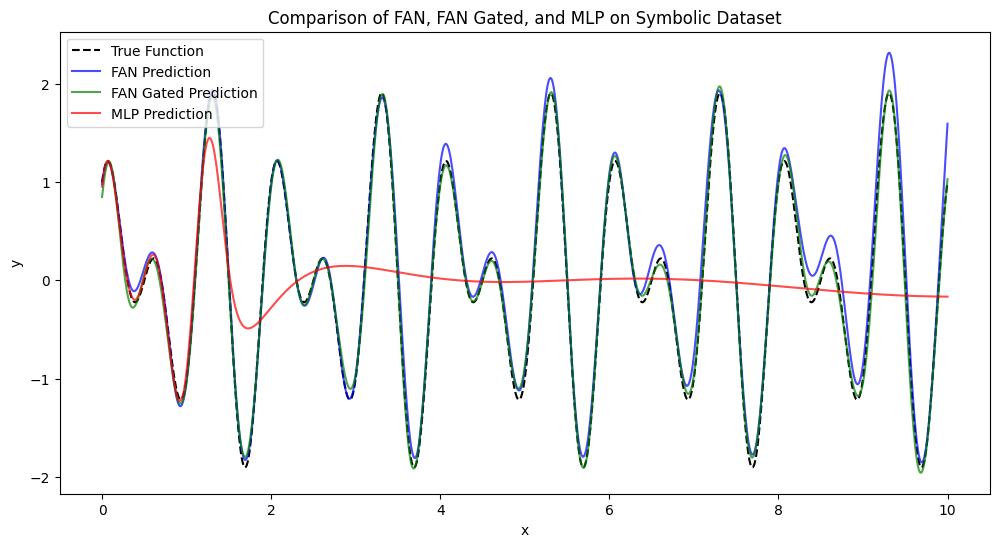

In [ ]:
# Using the evaluation function to plot results
evaluate_model(fan_model, fan_gate_model, mlp_model)

In [ ]:
# Evaluating the FFN implementations

fan_model=      FANFeedForward(1, 32, dropout=0.0, glu=False).to(device)
fan_gate_model= FANFeedForward(1, 32, dropout=0.0, glu=True).to(device)

# Training the FAN model
print("\nStarting training for FAN model...")
fan_train_losses, fan_val_losses= train_model(
    train_dataset, val_dataset, fan_model, epochs=500, batch_size=32, lr=0.001, model_name="FAN"
)

# Training the FAN Gated model
print("\nStarting training for FAN Gated model...")
fang_train_losses, fang_val_losses= train_model(
    train_dataset, val_dataset, fan_gate_model, epochs=500, batch_size=32, lr=0.001, model_name="FAN"
)


Starting training for FAN model...


Training FAN:   0%|          | 2/500 [00:00<00:38, 12.88it/s]

Epoch 1/500 - FAN Training Loss: 156.615156, Validation Loss: 97.259628


Training FAN:  10%|█         | 50/500 [00:03<00:42, 10.51it/s]

Epoch 50/500 - FAN Training Loss: 0.307799, Validation Loss: 0.271989


Training FAN:  20%|██        | 102/500 [00:08<00:28, 13.89it/s]

Epoch 100/500 - FAN Training Loss: 0.076635, Validation Loss: 0.052381


Training FAN:  30%|███       | 152/500 [00:11<00:26, 13.16it/s]

Epoch 150/500 - FAN Training Loss: 0.029239, Validation Loss: 0.025057


Training FAN:  40%|████      | 202/500 [00:16<00:28, 10.56it/s]

Epoch 200/500 - FAN Training Loss: 0.021950, Validation Loss: 0.023073


Training FAN:  50%|█████     | 252/500 [00:20<00:19, 12.99it/s]

Epoch 250/500 - FAN Training Loss: 0.021228, Validation Loss: 0.017701


Training FAN:  60%|██████    | 302/500 [00:23<00:14, 13.69it/s]

Epoch 300/500 - FAN Training Loss: 0.021212, Validation Loss: 0.032301


Training FAN:  70%|███████   | 352/500 [00:27<00:10, 14.19it/s]

Epoch 350/500 - FAN Training Loss: 0.018457, Validation Loss: 0.035890


Training FAN:  80%|████████  | 402/500 [00:32<00:07, 13.70it/s]

Epoch 400/500 - FAN Training Loss: 0.025171, Validation Loss: 0.018276


Training FAN:  90%|█████████ | 452/500 [00:35<00:03, 13.57it/s]

Epoch 450/500 - FAN Training Loss: 0.024102, Validation Loss: 0.018720


Training FAN: 100%|██████████| 500/500 [00:39<00:00, 12.71it/s]


Epoch 500/500 - FAN Training Loss: 0.018881, Validation Loss: 0.020344

Starting training for FAN Gated model...


Training FAN:   0%|          | 2/500 [00:00<00:39, 12.52it/s]

Epoch 1/500 - FAN Training Loss: 317.698193, Validation Loss: 189.332038


Training FAN:  10%|█         | 51/500 [00:04<00:39, 11.36it/s]

Epoch 50/500 - FAN Training Loss: 0.911570, Validation Loss: 0.988780


Training FAN:  20%|██        | 101/500 [00:08<00:30, 13.21it/s]

Epoch 100/500 - FAN Training Loss: 0.857978, Validation Loss: 0.886943


Training FAN:  30%|███       | 151/500 [00:12<00:26, 13.17it/s]

Epoch 150/500 - FAN Training Loss: 0.675246, Validation Loss: 0.736407


Training FAN:  40%|████      | 201/500 [00:16<00:35,  8.52it/s]

Epoch 200/500 - FAN Training Loss: 0.518367, Validation Loss: 0.533080


Training FAN:  50%|█████     | 252/500 [00:21<00:19, 12.93it/s]

Epoch 250/500 - FAN Training Loss: 0.437318, Validation Loss: 0.450373


Training FAN:  60%|██████    | 302/500 [00:24<00:14, 13.57it/s]

Epoch 300/500 - FAN Training Loss: 0.415374, Validation Loss: 0.401633


Training FAN:  70%|███████   | 351/500 [00:29<00:16,  8.82it/s]

Epoch 350/500 - FAN Training Loss: 0.392925, Validation Loss: 0.398323


Training FAN:  80%|████████  | 402/500 [00:33<00:07, 12.59it/s]

Epoch 400/500 - FAN Training Loss: 0.379601, Validation Loss: 0.420724


Training FAN:  90%|█████████ | 452/500 [00:37<00:03, 13.36it/s]

Epoch 450/500 - FAN Training Loss: 0.368872, Validation Loss: 0.365188


Training FAN: 100%|██████████| 500/500 [00:41<00:00, 12.09it/s]

Epoch 500/500 - FAN Training Loss: 0.334614, Validation Loss: 0.307994


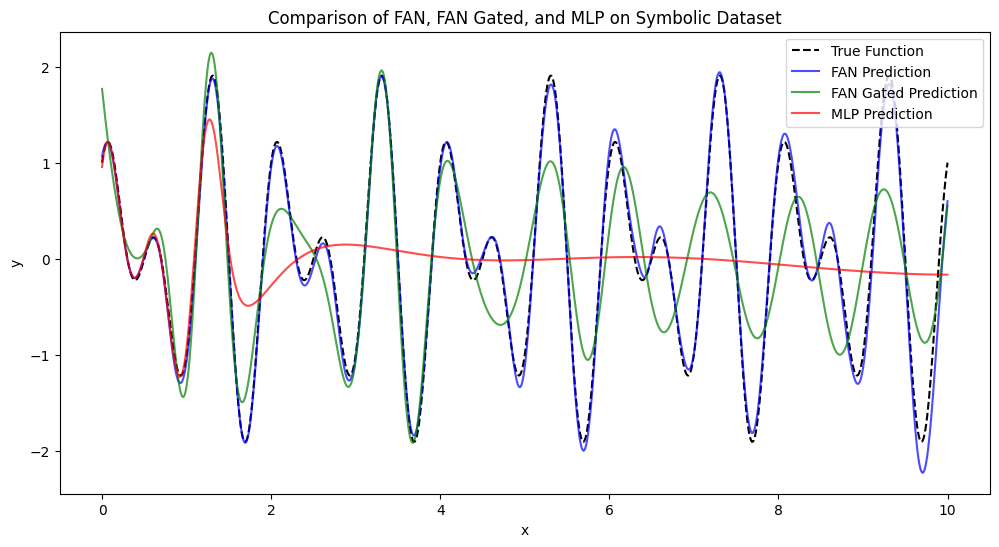

In [ ]:
# Using the evaluation function to plot results
evaluate_model(fan_model, fan_gate_model, mlp_model)

In [ ]:
# https://github.com/YihongDong/FAN/
# https://github.com/YihongDong/FAN/blob/main/Timeseries_Forecasting/layers/Transformer_EncDec.py
# https://levelup.gitconnected.com/fourier-analysis-networks-fans-are-here-to-break-barriers-in-ai-1c521c6656bc